In [ ]:
# Matplotlib settings

import warnings
import matplotlib.pyplot as plt
#sns.set_style("whitegrid")

plt.rcParams.update({
    'text.usetex': True,          # Enable LaTeX rendering
    'font.family': 'serif',       # Use serif fonts for a classic look
    'font.serif': ['Georgia'],    # Specify a serif font (e.g., Georgia)
    'figure.dpi': 200,            # Set the default DPI for clear visuals
    'figure.facecolor': 'white',  # Set the figure background color
    "axes.edgecolor": "grey",     # Border color for axes
    "axes.linewidth": 0.2,        # Border width for axes
    'axes.grid': True,            # Enable grid on axes
    'grid.color': 'grey',         # Grid color
    'grid.linestyle': '--',       # Dashed grid line style
    'grid.linewidth': 0.3,       # Grid line width
    'grid.alpha': 0.5,            # Grid transparency
    "axes.spines.top": False,     # Remove top spine
    "axes.spines.right": False,   # Remove right spine
    "legend.frameon": True,       # Enable frame around legends
    "legend.framealpha": 0.5      # Legend frame transparency
})

plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"

warnings.filterwarnings('ignore')

legend_box = dict(boxstyle="round,pad=0.3", fc="white", ec="0.8", alpha=0.9)

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import entropy, pearsonr
from SHAP_utils.load_breast_cancer import load_breast_cancer_dataset

In [ ]:
def freedman_diaconis_bins(x):
    x = np.asarray(x)
    iqr = np.subtract(*np.percentile(x, [75, 25]))
    n = len(x)
    if iqr == 0: return int(np.sqrt(n))
    bin_width = 2 * iqr / (n ** (1 / 3))
    bins = int(np.ceil((x.max() - x.min()) / bin_width))
    return max(2, bins)

def shannon_entropy(x, bins):
    hist, _ = np.histogram(x, bins=bins, density=False)
    prob = hist / hist.sum()
    prob = prob[prob > 0]
    return entropy(prob, base=2)

def mutual_information(x, y, bins_x, bins_y):
    joint_hist, _, _ = np.histogram2d(x, y, bins=[bins_x, bins_y])
    joint_prob = joint_hist / joint_hist.sum()
    px = joint_prob.sum(axis=1)
    py = joint_prob.sum(axis=0)
    mi = 0.0
    for i in range(joint_prob.shape[0]):
        for j in range(joint_prob.shape[1]):
            if joint_prob[i, j] > 0:
                mi += joint_prob[i, j] * np.log2(joint_prob[i, j] / (px[i] * py[j]))
    return mi

def normalized_mutual_information(x, y):
    bx = freedman_diaconis_bins(x)
    by = freedman_diaconis_bins(y)
    hx = shannon_entropy(x, bx)
    hy = shannon_entropy(y, by)
    mi = mutual_information(x, y, bx, by)
    denominator = np.sqrt(hx * hy)
    if denominator == 0: 
        return 0.0
    return mi / denominator

def lower_scatter(x, y, **kwargs):
    sns.scatterplot(
        x=x, y=y, hue=df["target"],
        palette={0: "#FF0051", 1: "#008BFB"},
        alpha=0.5, s=20, legend=False
    )

def upper_nmi_corr(x, y, **kwargs):
    ax = plt.gca()
    nmi = normalized_mutual_information(x, y)
    rho, _ = pearsonr(x, y)

    label_text = f"$\\mathbf{{NMI}}: {nmi:.2f}$\n$\\mathbf{{Pearson}}: {rho:.2f}$"
    
    ax.annotate(
        label_text,
        xy=(0.5, 0.5), xycoords="axes fraction",
        ha="center", va="center",
        fontsize=20, 
        color="#333333"
    )
    ax.set_axis_off()

def diag_kde(x, **kwargs):
    sns.kdeplot(x=x[df["target"] == 0], color="#FF0051", linewidth=2, fill=True, alpha=0.1)
    sns.kdeplot(x=x[df["target"] == 1], color="#008BFB", linewidth=2, fill=True, alpha=0.1)

<Figure size 1200x1200 with 0 Axes>

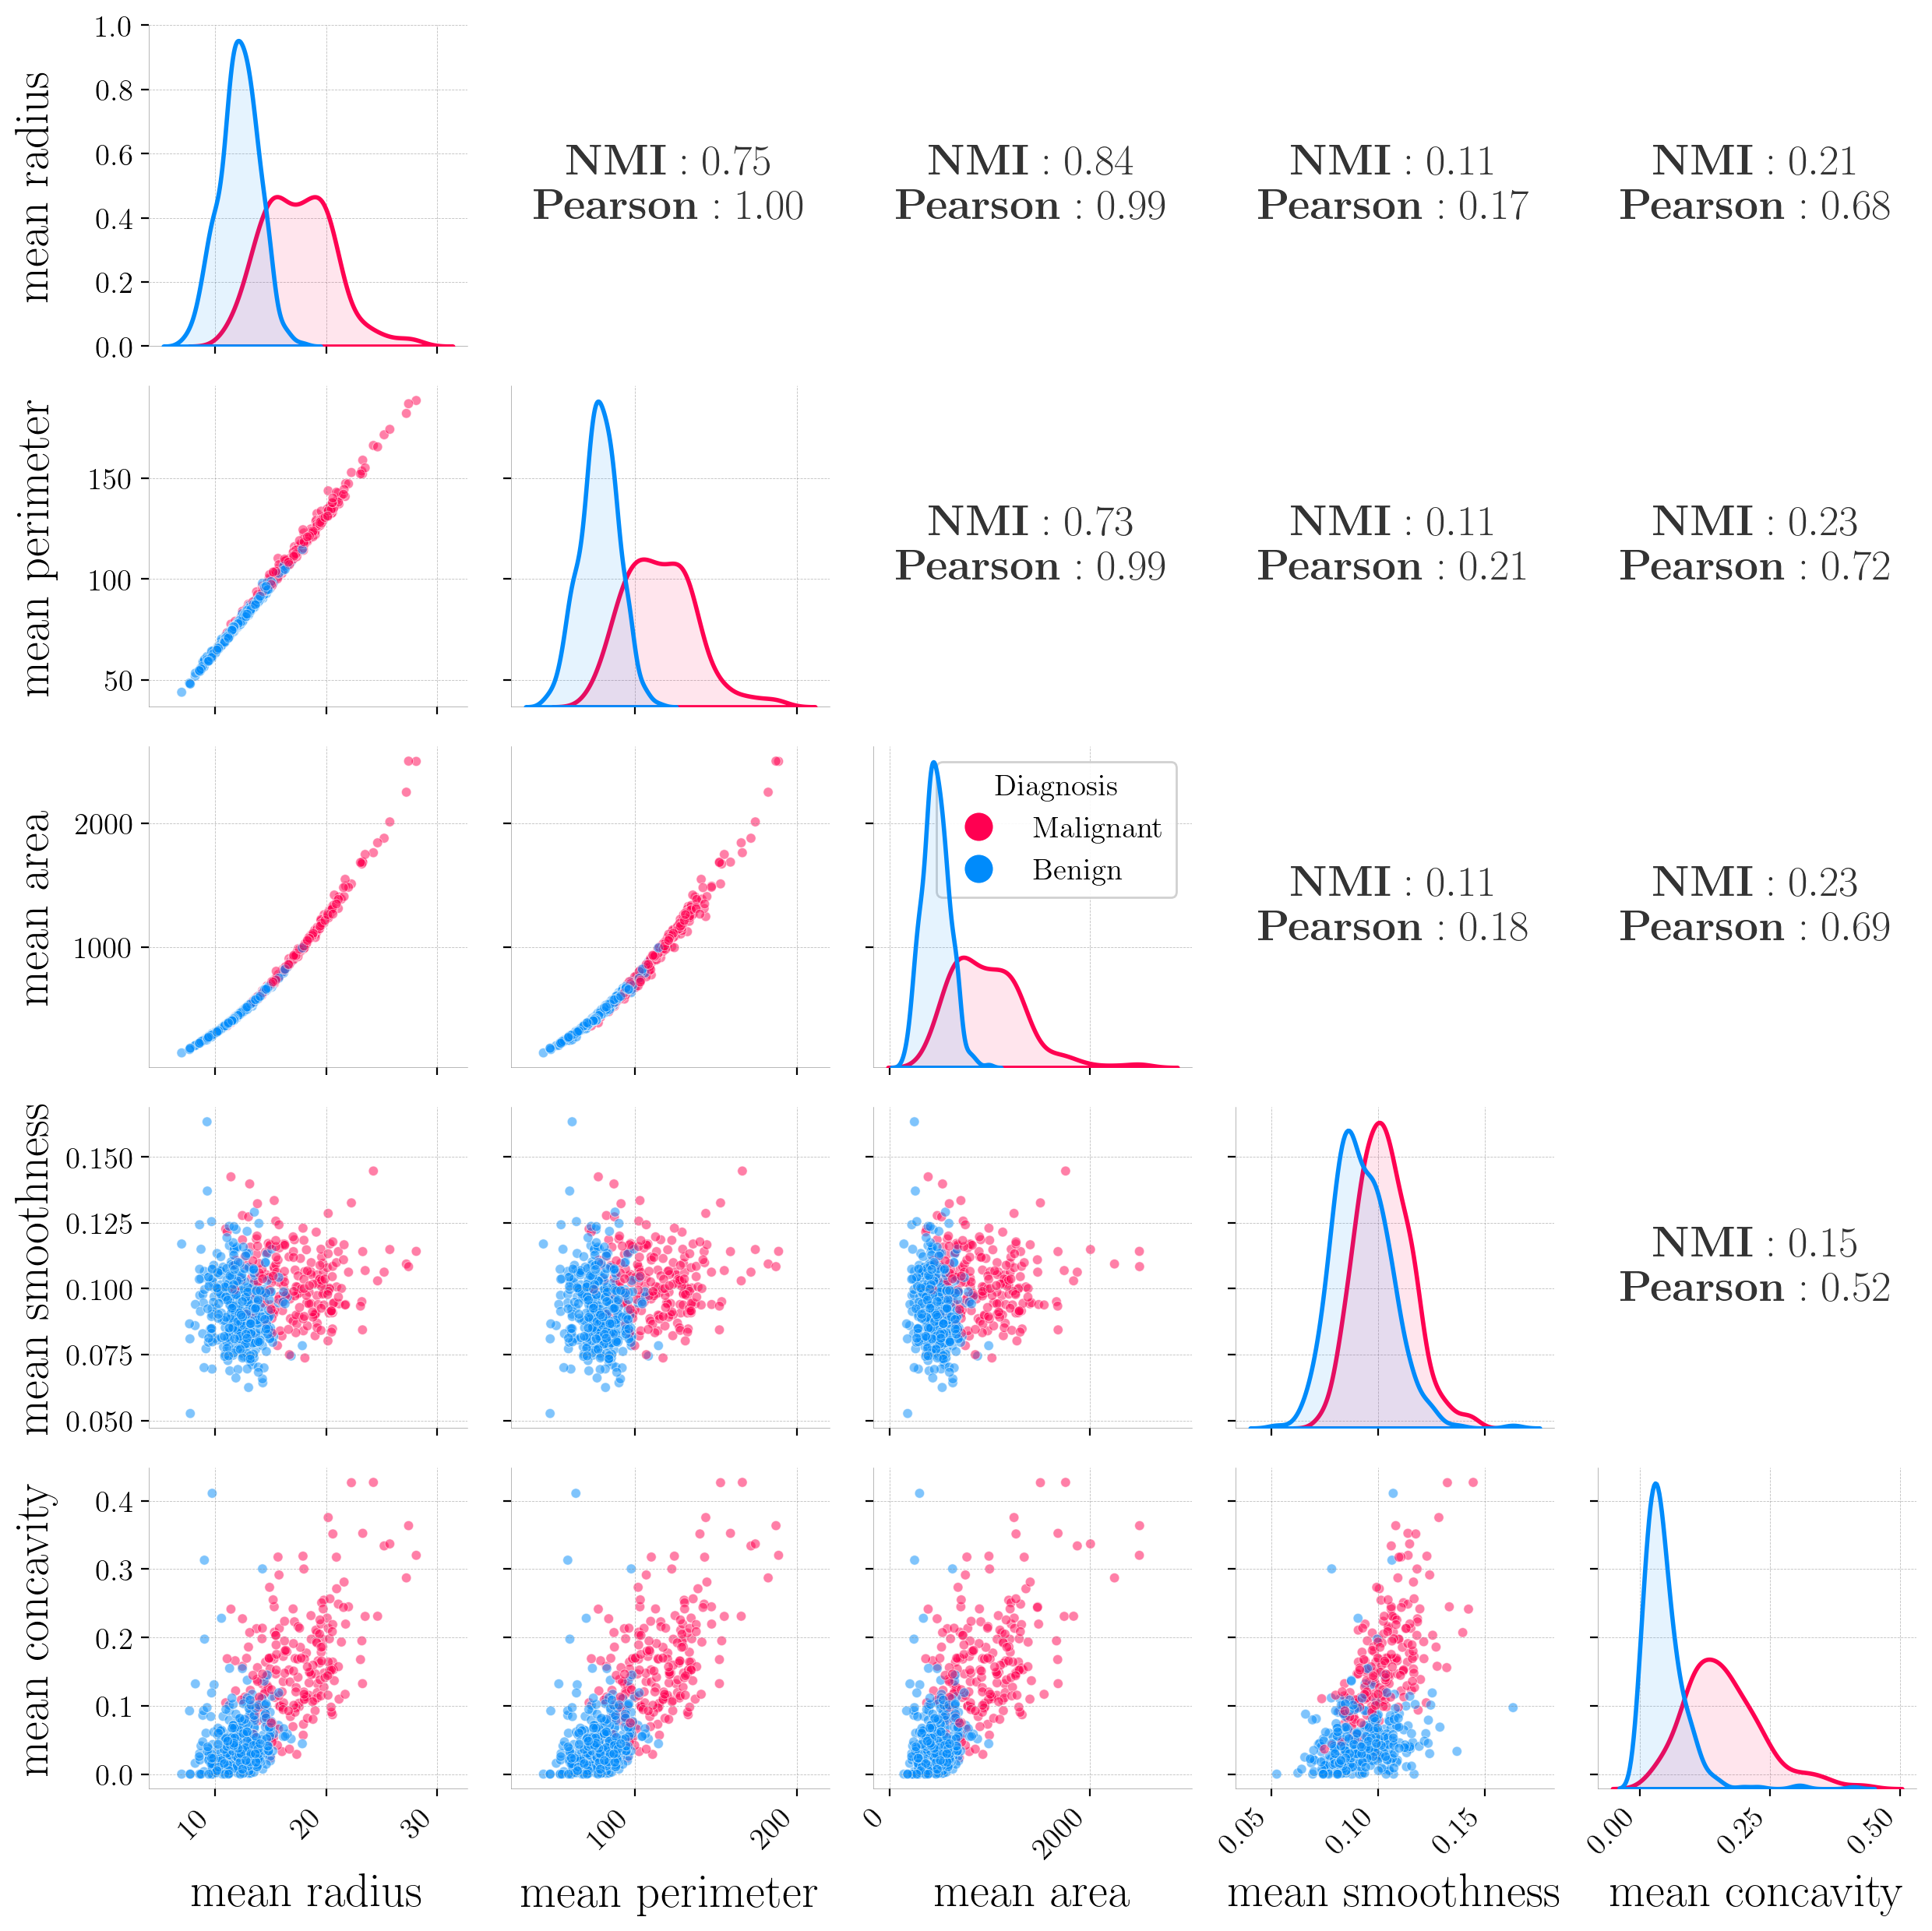

In [ ]:
data = load_breast_cancer_dataset(r"PATH_TO_DATA_FOLDER")
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target 

features = [
    "mean radius", "mean perimeter", "mean area",
    "mean smoothness", "mean concavity"
]
df = df[features + ["target"]]

plt.figure(figsize=(6, 6))

g = sns.PairGrid(
    df,
    vars=features,
    height=2.5,
    aspect=1,
    diag_sharey=False 
)

g.map_lower(lower_scatter)
g.map_upper(upper_nmi_corr)
g.map_diag(diag_kde)

for ax in g.axes.flatten():
    ax.xaxis.label.set_size(22)
    ax.yaxis.label.set_size(22)
    ax.xaxis.label.set_weight("bold")
    ax.yaxis.label.set_weight("bold")
    ax.tick_params(axis='both', which='major', labelsize=14)

for ax in g.axes[-1, :]:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

handles = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#FF0051", label="Malignant", markersize=14),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor="#008BFB", label="Benign", markersize=14)
]

middle_ax = g.axes[2, 2]

middle_ax.legend(
    handles=handles, 
    title="Diagnosis",
    loc="upper right",
    fontsize=14,
    title_fontsize=14,
    frameon=True,      
    facecolor='white', 
    framealpha=0.9     
)

g.figure.align_ylabels(g.axes[:, 0])

g.figure.align_xlabels(g.axes[-1, :])

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.datasets import load_breast_cancer
import pandas as pd

data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target 

print("Target Classes:", data.target_names)

label_mapping = {i: name for i, name in enumerate(data.target_names)}
print("Label Mapping:", label_mapping)

print("\nFirst 5 instances targets:", data.target[:5])
print("Corresponding labels:", [label_mapping[t] for t in data.target[:5]])

Target Classes: ['malignant' 'benign']
Label Mapping: {0: 'malignant', 1: 'benign'}

First 5 instances targets: [0 0 0 0 0]
Corresponding labels: ['malignant', 'malignant', 'malignant', 'malignant', 'malignant']
